Refrences :- 
* http://www.wildml.com/2015/09/recurrent-neural-networks-tutorial-part-1-introduction-to-rnns/
* https://github.com/lazyprogrammer/machine_learning_examples/tree/master/rnn_class

In [2]:
%autoreload 2
%load_ext autoreload

ERROR:root:Line magic function `%autoreload` not found.


In [3]:
import theano
import theano.tensor as T
import numpy as np 
import matplotlib.pyplot as plt 

In [4]:
from sklearn.utils import shuffle
from util import init_weight, get_robert_frost

In [5]:
class SimpleRNN:
    def __init__(self, D, M, V):
        self.D = D # dimensionality of word embedding
        self.M = M # hidden layer size
        self.V = V # vocabulary size

    def fit(self, X, learning_rate=10e-1, mu=0.99, reg=1.0, activation=T.tanh, epochs=500, show_fig=False):
        N = len(X)
        D = self.D
        M = self.M
        V = self.V
        self.f = activation

        # initial weights
        We = init_weight(V, D)
        Wx = init_weight(D, M)
        Wh = init_weight(M, M)
        bh = np.zeros(M)
        h0 = np.zeros(M)
        Z = np.ones(M)
        Wo = init_weight(M, V)
        bo = np.zeros(V)
        
        thX, thY, py_x, prediction = self.set(We, Wx, Wh, bh, h0, Z,  Wo, bo, activation)

        lr = T.scalar('lr')

        cost = -T.mean(T.log(py_x[T.arange(thY.shape[0]), thY]))
        grads = T.grad(cost, self.params)
        dparams = [theano.shared(p.get_value()*0) for p in self.params]

        updates = [
            (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
        ] + [
            (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
        ]

        self.predict_op = theano.function(inputs=[thX], outputs=prediction)
        self.train_op = theano.function(
            inputs=[thX, thY],
            outputs=[cost, prediction],
            updates=updates
        )

        costs = []
        for i in xrange(epochs):
            X = shuffle(X)
            n_correct = 0
            n_total = 0 
            cost = 0
            for j in xrange(N):
                if np.random.random() < 0.1:
                    input_sequence = [0] + X[j]
                    output_sequence = X[j] + [1]
                else:
                    input_sequence = [0] + X[j][:-1]
                    output_sequence = X[j]
                    
                n_total += len(output_sequence)
                    
                # we set 0 to start and 1 to end
                c, p = self.train_op(input_sequence, output_sequence)
                # print "p:", p
                cost += c
                # print "j:", j, "c:", c/len(X[j]+1)
                for pj, xj in zip(p, output_sequence):
                    if pj == xj:
                        n_correct += 1
            print "i:", i, "cost:", cost, "correct rate:", (float(n_correct)/n_total)
            costs.append(cost)

        if show_fig:
            plt.plot(costs)
            plt.show()
    
    def save(self, filename):
        np.savez(filename, *[p.get_value() for p in self.params])

    @staticmethod
    def load(filename, activation):
        # TODO: would prefer to save activation to file too
        npz = np.load(filename)
        We = npz['arr_0']
        Wx = npz['arr_1']
        Wh = npz['arr_2']
        bh = npz['arr_3']
        h0 = npz['arr_4']
        Z  = npz['arr_5']
        Wo = npz['arr_6']
        bo = npz['arr_7']
        V, D = We.shape
        _, M = Wx.shape
        rnn = SimpleRNN(D, M, V)
        rnn.set(We, Wx, Wh, bh, h0, Z, Wo, bo, activation)
        return rnn

    def set(self, We, Wx, Wh, bh, h0, Z, Wo, bo, activation):
        self.f = activation

        # redundant - see how you can improve it
        self.We = theano.shared(We)
        self.Wx = theano.shared(Wx)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.h0 = theano.shared(h0)
        self.Z  = theano.shared(Z)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.We, self.Wx, self.Wh, self.bh, self.h0, self.Z, self.Wo, self.bo]

        thX = T.ivector('X')
        Ei = self.We[thX] # will be a TxD matrix
        thY = T.ivector('Y')

        def recurrence(x_t, h_t1):
            # returns h(t), y(t)
            hhat_t = self.f(x_t.dot(self.Wx) + h_t1.dot(self.Wh) + self.bh)
            h_t = (1 - Z) * h_t1 + self.Z * hhat_t
            y_t = T.nnet.softmax(h_t.dot(self.Wo) + self.bo)
            return h_t, y_t

        [h, y], _ = theano.scan(
            fn=recurrence,
            outputs_info=[self.h0, None],
            sequences=Ei,
            n_steps=Ei.shape[0],
        )

        py_x = y[:, 0, :]
        prediction = T.argmax(py_x, axis=1)
        self.predict_op = theano.function(
            inputs=[thX],
            outputs=[py_x, prediction],
            allow_input_downcast=True,
        )
        return thX, thY, py_x, prediction 

    def generate(self, word2idx):
        idx2word = {v:k for k,v in word2idx.iteritems()}
        V = len(word2idx)

        n_lines = 0

        X = [ 0 ]
        while n_lines < 4:
            # print "X:", X
            PY_X, _ = self.predict_op(X)
            PY_X = PY_X[-1].flatten()
            P = [ np.random.choice(V, p=PY_X)]
            X = np.concatenate([X, P]) # append to the sequence
            P = P[-1] # just grab the most recent prediction
            if P > 1:
                word = idx2word[P]
                print word,
            elif P == 1:
                n_lines += 1
                X = [0]
                print ''
                


def train_poetry():
    sentences, word2idx = get_robert_frost()
    rnn = SimpleRNN(50, 50, len(word2idx))
    rnn.fit(sentences, learning_rate=10e-5, show_fig=True, activation=T.nnet.relu, epochs=2000)
    rnn.save('RRNN_D50_M50_epochs2000_relu.npz')

def generate_poetry():
    sentences, word2idx = get_robert_frost()
    rnn = SimpleRNN.load('RRNN_D50_M50_epochs2000_relu.npz', T.nnet.relu)
    rnn.generate(word2idx)

i: 0 cost: 10984.0297776 correct rate: 0.0485463774804
i: 1 cost: 10694.2152763 correct rate: 0.0503829473101
i: 2 cost: 9513.90904391 correct rate: 0.049043062201
i: 3 cost: 9112.25681702 correct rate: 0.0523555391976
i: 4 cost: 8999.82756265 correct rate: 0.0523454059534
i: 5 cost: 8929.98472782 correct rate: 0.0527529281564
i: 6 cost: 8868.68942511 correct rate: 0.0527478597073
i: 7 cost: 8814.06331215 correct rate: 0.0548348514123
i: 8 cost: 8759.82874103 correct rate: 0.0547213265776
i: 9 cost: 8704.26282104 correct rate: 0.0528298419699
i: 10 cost: 8658.33594662 correct rate: 0.0567617295308
i: 11 cost: 8597.64763985 correct rate: 0.0586882531506
i: 12 cost: 8552.9615313 correct rate: 0.0540714812085
i: 13 cost: 8495.76535003 correct rate: 0.0556882925933
i: 14 cost: 8434.78698015 correct rate: 0.0608207581892
i: 15 cost: 8390.52179269 correct rate: 0.0542057794957
i: 16 cost: 8350.50814275 correct rate: 0.0586826347305
i: 17 cost: 8304.17462673 correct rate: 0.0571007552035
i: 1

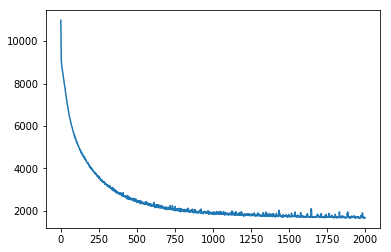

In [5]:
train_poetry()

In [9]:
generate_poetry()

behind the it two us 
had checked the she 
in one himself at the bed 
i end not it and in the two on 


In [10]:
generate_poetry()

whats this 
a small skiff home but it the cold to see to bed 
but only a an hour 
but not the color 


In [11]:
generate_poetry()

the only hillside in a all 
his lantern without a a house 
and youre a a movement toward them of the fast 
they dont know where the well when i were 
